## Variance Decompositions
Variance decomposition results for sections 5 and 6 of the paper.

#### Config

In [1]:
## load some packages
# model
from models.hankv2 import HANK
from toolkit.irfs import *

# general
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from cmcrameri import cm as cmc
import seaborn as sns
import pandas as pd
import numpy as np
import cmcrameri

## config
plt.rcParams.update({
        'text.usetex': True,
        'font.family': 'serif',
        'figure.titlesize': 'medium',
        'figure.labelsize': 'medium',
        'axes.titlesize': 'medium',
    })
cmap = 'cmc.batlow'
sns.set_palette(sns.color_palette(cmap, n_colors=7))
save = True

#### Solve the Model

In [2]:
## intialize model
mod_pars = {
        'gamma': 4., 'chi': 2.,  # household parameters, beta and phi are chosen in calibration
        'N_z': 7, 'rho_z': 0.963, 'sigma_z': 0.134,  # household state transitions
        'kappa': 0.1,  # philips curve
        'kappa_W': 0.1,
        'rho_B': 0.93, 'omega_pi': 1.5, 'omega_Y': 0.,  # govt parameters
        'A': 1., 'psi': 1.2, 'psiW': 1.2, 'g': 0.201, 'xi': 1., 'tauP': 1.18, 'eta': 0.081,  # shock steady states
        'epsA': 1., 'epspsi': 1., 'epspsiW': 1., 'epsg': 1., 'epsxi': 1., 'epstauP': 1., 'epseta': 1.,
        'pi': 1., 'B': 0.577,  # variable steady states we define (otherwise model can't be solved)
        'I': 1.005, 'Y': 1.,  # varaible steady states we target
        'N_a': 501, 'a_min': 0, 'a_max': 50,  # grid states
    }
hank = HANK(**mod_pars)

## solve steady state
free = ['beta', 'phi']
endog = ['R', 'G', 'tauL', 'N', 'M', 'D', 'piW', 'L', 'curlN', 'curlC', 'curlB']
markets = {m: HANK.markets[m] for m in ['mkt3', 'mkt4']}  # the other markets clear by definition or by an analytic form
V_a0 = (hank.a_grid[:, None] * (hank.I - 1) + hank.z_grid)**(-hank.gamma)
X0 = np.array([0.9, 0.1])
hank.solve_ss(free, endog, V_a0, X0, markets=markets)
assert np.isclose(hank.curlC + hank.G - hank.Y, 0)  # walras

## solve for perturbation matrix
T = 300
G, dxs = hank.solve_G(T, ha=True, h=1e-4)

f'phi = {hank.phi}; beta = {hank.beta}'

'phi = 3.1554601309064183; beta = 0.944885031287334'

#### Estimates
Plug in the estimates we found earlier

In [3]:
## run instead of estiation, loads from file
res_df = pd.read_csv('data/bayes_results.csv', index_col=0)
shock_pars = res_df['mean'].to_dict()  # save the means to a dictaionary
rhos = {p.split('_')[1]: v for p, v in shock_pars.items() if p.startswith('rho')}
sigmas = {p.split('_')[1]: v for p, v in shock_pars.items() if p.startswith('sigma')}

#### Variance Decomposition (Aggs)

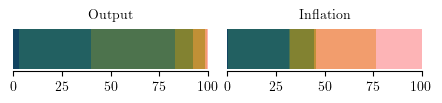

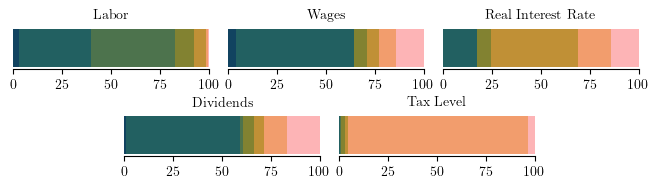

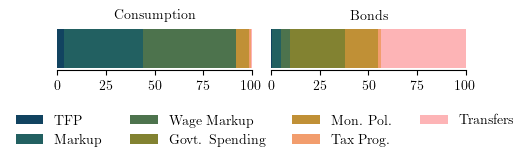

In [4]:
## get variaences
vars = all_shock_variences(all_shock_irfs(G, rhos, T, sigma=sigmas), h=4)
# labels = {   # keys for labeling
#         'epsA': '$A$', 'epspsi': r'$\psi$', 'epspsiW': r'$\psi_W$', 'epsg': '$g$', 'epsxi': r'$\xi$', 'epstauP': r'$\tau^P$', 'epseta': r'$\eta$',  # shocks
#         'pi': r'$\pi$', 'W': '$W$', 'M': '$M$', 'D': '$D$', 'R': '$R$', 'I': '$I$', 'tauL': r'$\tau^L$',  # prices
#         'curlC': '$C$', 'curlB': '$B$',  # hh aggs
#         'Y': '$Y$', 'N': '$N$', 'B': '$B$', 'G': '$G$', 'L': '$L$',  # econ aggs
#     }
labels = {   # keys for labeling
        'epsA': 'TFP', 'epspsi': 'Markup', 'epspsiW': 'Wage Markup', 'epsg': 'Govt. Spending', 'epsxi': 'Mon. Pol.', 'epstauP': 'Tax Prog.', 'epseta': 'Transfers',  # shocks
        'pi': 'Inflation', 'W': 'Wages', 'M': '$M$', 'D': 'Dividends', 'R': 'Real Interest Rate', 'I': 'Interst Rate', 'tauL': 'Tax Level',  # prices
        'curlC': 'Consumption', 'curlB': 'Bonds',  # hh aggs
        'Y': 'Output', 'N': 'Labor', 'B': 'Bonds', 'G': 'Govt. Spending', 'L': 'Labor',  # econ aggs
    }

def plot_var_decomp(var, ax):
    # format graph
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticks([])
    ax.set_xlim(0, 100)

    # varience decompoisiont
    shock_pct = np.array(list(var.values()))
    shock_pct = 100 * shock_pct / shock_pct.sum()
    shock_pct_start = shock_pct.cumsum() - shock_pct
    for i, s in enumerate(var.keys()):
        ax.barh('h', shock_pct[i], left=shock_pct_start[i], label=labels[s])

## make the plots
for outcomes, t in zip([['Y', 'pi'], ['L', 'W', 'R', 'D', 'tauL'], ['curlC', 'curlB']], ['agg', 'hh_dec', 'hh_agg']):
    w = min(len(outcomes), 3)
    h = -(-len(outcomes) // 3)
    fig, axs = plt.subplots(h, w)
    fig.set_figwidth(6.5 / 3 * w)
    fig.set_figheight(0.1 + 0.85 * h)
    for i, X in enumerate(outcomes):
        axs.take(i).set_title(labels[X])
        plot_var_decomp(vars[X], axs.take(i))
    n_empty = w * h - len(outcomes)
    for i in range(n_empty):
        axs[-1, -1 - i].axis('off')
    fig.tight_layout(pad=0.4)
    if n_empty > 0:
        xs = 0.5 - (axs[-1, 0].get_position().x0 + axs[-1, w - n_empty - 1].get_position().x1) / 2
        for i in range(w - n_empty):
            (x0, y0), (x1, y1) = axs[-1, i].get_position().get_points()
            axs[-1, i].set_position([x0 + xs, y0, x1 - x0, y1 - y0])
    if save: fig.savefig('paper/figures/var_decomp_' + t + '.pgf')
fig.set_figheight(0.7 + 0.85 * h)
fig.tight_layout(pad=0.4)
fig.subplots_adjust(bottom=4/7)
fig.legend(*axs[0].get_legend_handles_labels(), ncol=4, loc='lower center', bbox_to_anchor=(0.5, 0), frameon=False)
if save: fig.savefig('paper/figures/var_decomp_' + t + '.pgf', bbox_inches='tight')

### IRFs
IRFs for each of the shocks. These go in the appendix.

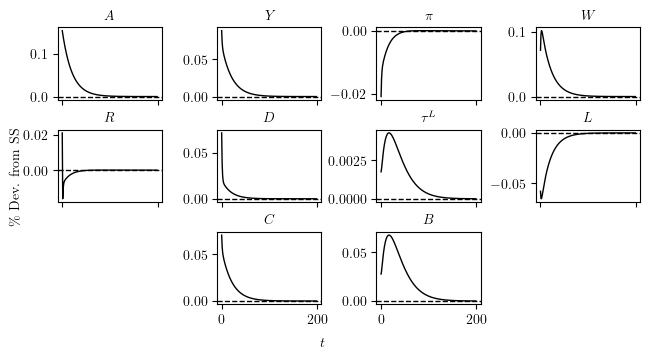

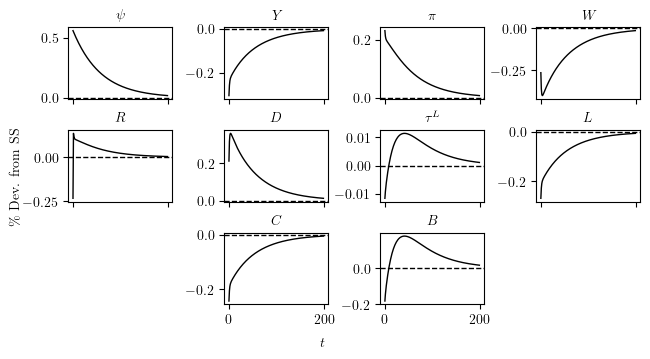

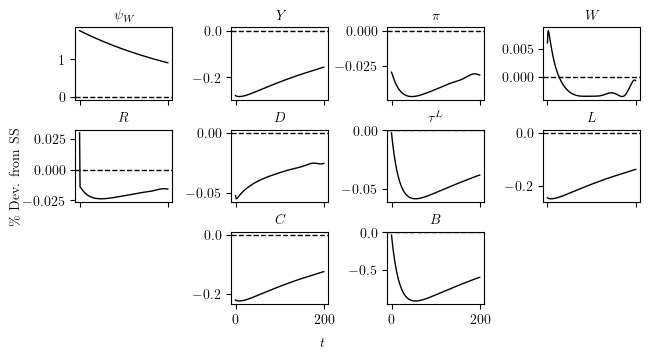

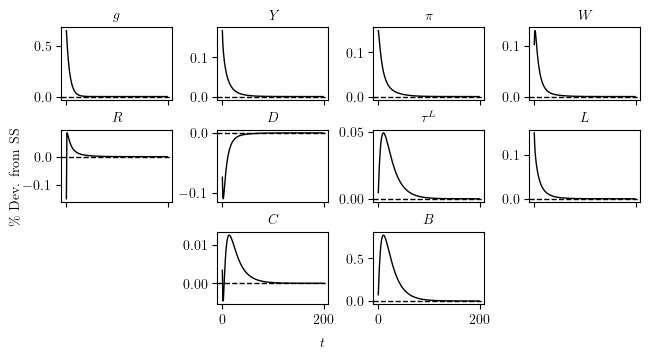

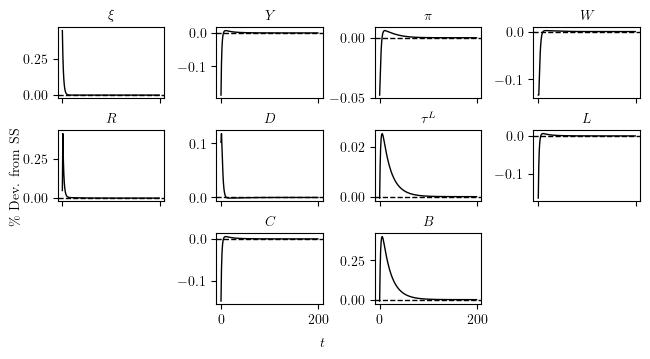

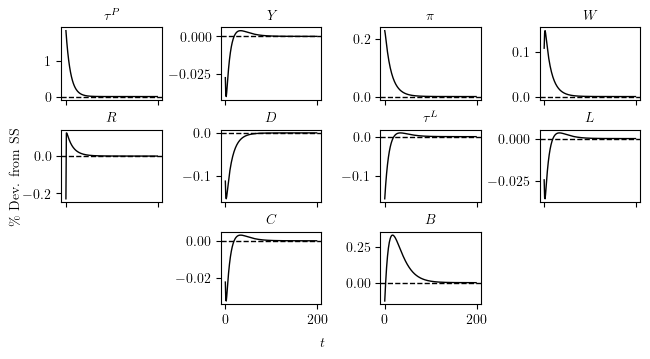

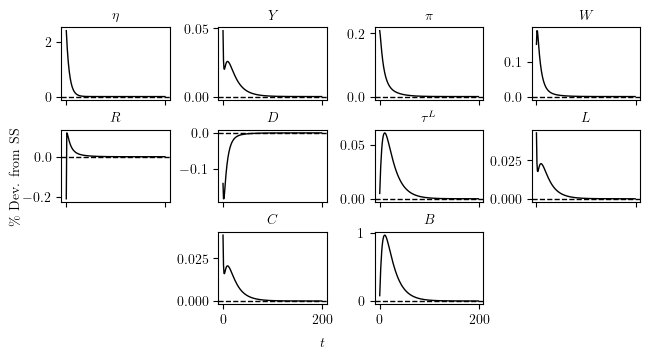

In [5]:
tmax = 200
labels = {   # keys for labeling
        'epsA': '$A$', 'epspsi': r'$\psi$', 'epspsiW': r'$\psi_W$', 'epsg': '$g$', 'epsxi': r'$\xi$', 'epstauP': r'$\tau^P$', 'epseta': r'$\eta$',  # shocks
        'pi': r'$\pi$', 'W': '$W$', 'M': '$M$', 'D': '$D$', 'R': '$R$', 'I': '$I$', 'tauL': r'$\tau^L$',  # prices
        'curlC': '$C$', 'curlB': '$B$',  # hh aggs
        'Y': '$Y$', 'N': '$N$', 'B': '$B$', 'G': '$G$', 'L': '$L$',  # econ aggs
    }

for Z in hank.shocks:
    # solve irfs
    X_irfs, Z_irf = single_shock_irfs(G[Z], rhos[Z], T, sigma=sigmas[Z])

    # plot setup
    fig, axs = plt.subplots(3, 4, sharex=True)
    fig.set_figwidth(6.5)
    fig.set_figheight(3.5)
    fig.supxlabel('$t$')
    fig.supylabel(r'\% Dev. from SS')
    axs[2, 0].set_axis_off()
    axs[2, 3].set_axis_off()
    axs = np.delete(axs.flatten(), [8, 11])
    outcomes = ['Y', 'pi', 'W', 'R', 'D', 'tauL', 'L', 'curlC', 'curlB']

    # plot each irf
    axs[0].set_title(labels[Z])
    axs[0].plot(Z_irf[:tmax], '-k', linewidth=1)
    axs[0].axhline(0, c='k', ls='--', linewidth=1)
    for ax, X in zip(axs[1:], outcomes):
        ax.set_title(labels[X])
        ax.plot(X_irfs[X][:tmax], '-k', linewidth=1)
        ax.axhline(0, c='k', ls='--', linewidth=1)

    # final things
    fig.tight_layout(pad=0.5)
    if save: fig.savefig(f'paper/figures/{Z[3:]}_agg_irf.pgf')

#### HH Steady States
Table of information about household steady states.

In [6]:
## Areas of interest
wealth_percentiles = [0, 0.5, 0.9, 0.99]
income_percentiles = [0.1, 0.5, 0.9]
pts_a = np.searchsorted(hank.dist.sum(axis=1).cumsum(), wealth_percentiles)  # points on the asset grid, 50th, 90th, 99th percentile
pts_z = np.searchsorted(hank.z_dist.cumsum(), income_percentiles)  # points on the productivity grid, 10th, 50th, 90th percentile
hank.z_grid[pts_z], hank.a_grid[pts_a]

# make info
hh_df = pd.DataFrame(
        np.array([
            np.repeat(hank.z_grid[pts_z], len(wealth_percentiles)),
            np.tile(hank.a_grid[pts_a], (len(income_percentiles), 1)).ravel(),
            hank.c[pts_a][:, pts_z].T.ravel(),
            hank.a[pts_a][:, pts_z].T.ravel(),
        ]).T,
        columns=['z', 'wealth', 'c', 'a']
    )
hh_df['W'] = hh_df['z'] * hank.L * hank.W
hh_df['W_share'] = hh_df['W']
hh_df['R'] = hh_df['wealth'] * hank.R
hh_df['R_share'] = hh_df['R']
hh_df['T'] = hank.D + hank.eta
hh_df['T_share'] = hh_df['T'] 
hh_df['tau'] = -hank.tauL * hh_df['z']**hank.tauP
hh_df['tau_share'] = hank.tauL * hh_df['z']**hank.tauP
hh_df['total'] = hh_df['W'] + hh_df['R'] + hh_df['T'] + hh_df['tau']
hh_df['total_share'] = hh_df['total']
hh_df[['W_share', 'R_share', 'T_share', 'tau_share', 'total_share']] = hh_df[['W_share', 'R_share', 'T_share', 'tau_share', 'total_share']].div(hh_df['total'].values, axis=0) * 100

hh_df.T

,0,1,2,3,4,5,6,7,8,9,10,11
z,0.443992,0.443992,0.443992,0.443992,1.000000,1.000000,1.000000,1.000000,2.252291,2.252291,2.252291,2.252291
wealth,0.000000,0.039830,1.874048,5.896041,0.000000,0.039830,1.874048,5.896041,0.000000,0.039830,1.874048,5.896041
c,0.482757,0.506732,0.696254,0.896486,0.744493,0.754108,0.897784,1.078968,1.108667,1.111029,1.200052,1.351746
a,0.000000,0.016053,1.669921,5.511791,0.000000,0.030414,1.730127,5.591045,0.172849,0.210516,1.964882,5.855292
W,0.327247,0.327247,0.327247,0.327247,0.737055,0.737055,0.737055,0.737055,1.660062,1.660062,1.660062,1.660062
W_share,67.787113,62.596760,13.830201,5.106625,99.000906,93.949558,28.047173,11.050274,129.538858,125.615200,52.451693,23.033901
R,0.000000,0.040029,1.883418,5.925521,0.000000,0.040029,1.883418,5.925521,0.000000,0.040029,1.883418,5.925521
R_share,0.000000,7.656843,79.597596,92.466672,0.000000,5.102325,71.669782,88.838209,0.000000,3.028943,59.508912,82.218539
T,0.247667,0.247667,0.247667,0.247667,0.247667,0.247667,0.247667,0.247667,0.247667,0.247667,0.247667,0.247667
T_share,51.302602,47.374443,10.466964,3.864793,33.266487,31.569123,9.424469,3.713136,19.326061,18.740686,7.825332,3.436456


#### HH Decision Rules
Appendix

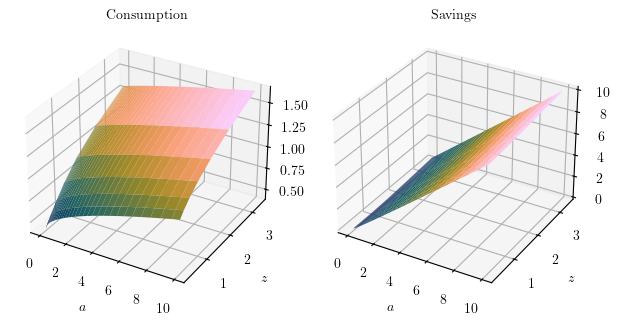

In [7]:
## plot setup
fig, axs = plt.subplots(1, 2, subplot_kw=dict(projection='3d'))
fig.set_figwidth(6.5)
fig.set_figheight(3.5)
for ax in axs:
    ax.set_xlabel('$a$')
    ax.set_ylabel('$z$')

## plot each thing
n = (hank.a_grid <= 10).sum()
axs[0].set_title('Consumption')
axs[0].plot_surface(X=np.tile(hank.a_grid[:n], (hank.N_z, 1)).T, Y=np.tile(hank.z_grid, (n, 1)), Z=hank.c[:n], cmap=cmap)
axs[1].set_title('Savings')
axs[1].plot_surface(X=np.tile(hank.a_grid[:n], (hank.N_z, 1)).T, Y=np.tile(hank.z_grid, (n, 1)), Z=hank.a[:n], cmap=cmap)

# final things
fig.tight_layout(pad=2.5)
if save: fig.savefig('paper/figures/policy_rule_surface.pgf')

#### HH Income

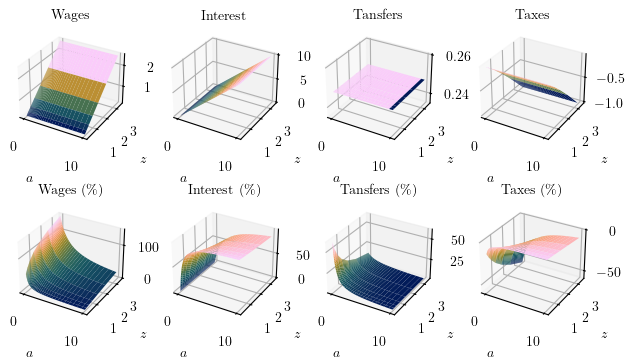

In [8]:
## get elements
n = (hank.a_grid <= 10).sum()
W_act = hank.z_grid * hank.L * hank.W
R_act = (hank.a_grid[:n] * hank.R)[:, None]
T_act = hank.D + hank.eta
tau_act = -hank.tauL * hank.z_grid**hank.tauP
total = W_act + R_act + T_act + tau_act
W_pct = 100 * W_act / total
R_pct = 100 * R_act / total
T_pct = 100 * T_act / total
tau_pct = 100 * tau_act / total

## plot it
fig, axs = plt.subplots(2, 4, subplot_kw=dict(projection='3d'))
fig.set_figwidth(6.5)
fig.set_figheight(4)
for ax in axs.ravel():
    ax.set_xlabel('$a$')
    ax.set_ylabel('$z$')

## plot each thing
axs[0, 0].set_title(r'Wages')
axs[0, 0].plot_surface(X=np.tile(hank.a_grid[:n], (hank.N_z, 1)).T, Y=np.tile(hank.z_grid, (n, 1)), Z=W_act + total * 0, cmap=cmap)
axs[0, 1].set_title(r'Interest')
axs[0, 1].plot_surface(X=np.tile(hank.a_grid[:n], (hank.N_z, 1)).T, Y=np.tile(hank.z_grid, (n, 1)), Z=R_act + total * 0, cmap=cmap)
axs[0, 2].set_title(r'Tansfers')
axs[0, 2].plot_surface(X=np.tile(hank.a_grid[:n], (hank.N_z, 1)).T, Y=np.tile(hank.z_grid, (n, 1)), Z=T_act + total * 0, cmap=cmap)
axs[0, 3].set_title(r'Taxes')
axs[0, 3].plot_surface(X=np.tile(hank.a_grid[:n], (hank.N_z, 1)).T, Y=np.tile(hank.z_grid, (n, 1)), Z=tau_act + total * 0, cmap=cmap)

axs[1, 0].set_title(r'Wages (\%)')
axs[1, 0].plot_surface(X=np.tile(hank.a_grid[:n], (hank.N_z, 1)).T, Y=np.tile(hank.z_grid, (n, 1)), Z=W_pct, cmap=cmap)
axs[1, 1].set_title(r'Interest (\%)')
axs[1, 1].plot_surface(X=np.tile(hank.a_grid[:n], (hank.N_z, 1)).T, Y=np.tile(hank.z_grid, (n, 1)), Z=R_pct, cmap=cmap)
axs[1, 2].set_title(r'Tansfers (\%)')
axs[1, 2].plot_surface(X=np.tile(hank.a_grid[:n], (hank.N_z, 1)).T, Y=np.tile(hank.z_grid, (n, 1)), Z=T_pct, cmap=cmap)
axs[1, 3].set_title(r'Taxes (\%)')
axs[1, 3].plot_surface(X=np.tile(hank.a_grid[:n], (hank.N_z, 1)).T, Y=np.tile(hank.z_grid, (n, 1)), Z=tau_pct, cmap=cmap)

# final things
fig.tight_layout(pad=2.5)
if save: fig.savefig('paper/figures/hh_income_surface.pgf')

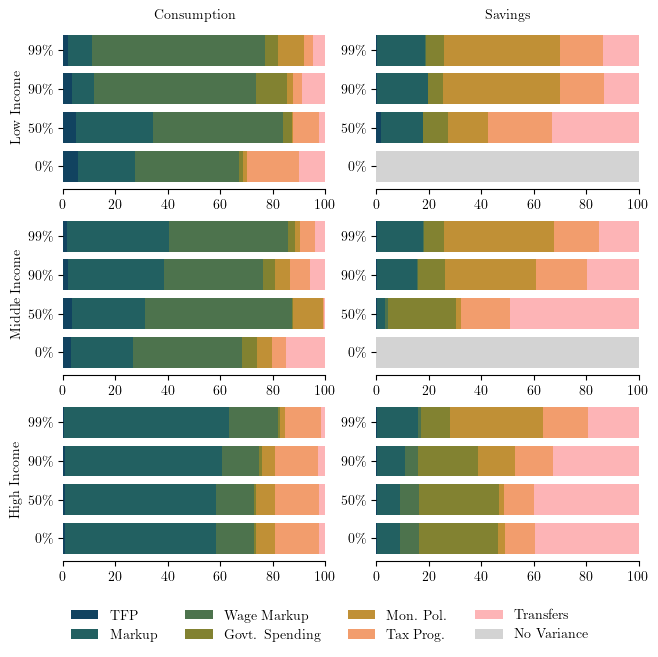

In [9]:
## get variences
vars = all_shock_variences(all_shock_irfs(G, rhos, T, sigma=sigmas, dxs=dxs), h=4)
pts_a = np.searchsorted(hank.dist.sum(axis=1).cumsum(), [0, 0.5, 0.9, 0.99])  # points on the asset grid, 50th, 90th, 99th percentile
pts_z = np.searchsorted(hank.z_dist.cumsum(), [0.1, 0.5, 0.9])  # points on the productivity grid, 10th, 50th, 90th percentile
vars = {x: {Z: var[pts_a][:, pts_z].T for Z, var in vars[x].items()} for x in ['c', 'a']}
# vars[x][Z][i][j] points to effect of Z on x at income i at asset grid j
labels = {   # keys for labeling
        'epsA': 'TFP', 'epspsi': 'Markup', 'epspsiW': 'Wage Markup', 'epsg': 'Govt. Spending', 'epsxi': 'Mon. Pol.', 'epstauP': 'Tax Prog.', 'epseta': 'Transfers',  # shocks
        'pi': 'Inflation', 'W': 'Wages', 'M': '$M$', 'D': 'Dividends', 'R': 'Real Interest Rate', 'I': 'Interst Rate', 'tauL': 'Tax Level',  # prices
        'curlC': 'Consumption', 'curlB': 'Bonds',  # hh aggs
        'Y': 'Output', 'N': 'Labor', 'B': 'Bonds', 'G': 'Govt. Spending', 'L': 'Labor',  # econ aggs
    }

## plot formatting
fig, axs = plt.subplots(3, 2)
fig.set_figwidth(6.5)
fig.set_figheight(6.5)

# titles
axs[0, 0].set_ylabel('Low Income')
axs[1, 0].set_ylabel('Middle Income')
axs[2, 0].set_ylabel('High Income')
axs[0, 0].set_title('Consumption')
axs[0, 1].set_title('Savings')

for i, x in enumerate(['c', 'a']):  # column, variable of interest
    # solve for varience
    var = np.array(list(vars[x].values()))  # get the variences into an array, use array operations to solve for percents
    total = var.sum(axis=0)
    total =  np.where(total != 0, total, 1)
    pct_var = 100 * var / total  # percent
    left_var = pct_var.cumsum(axis=0) - pct_var  # left side of bar

    for j in range(3):  # row, productivity level
        # formatting
        ax = axs[j, i]
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlim(0, 100)

        # plot each shock effect
        for k, s in enumerate(hank.shocks):
            ax.barh([r'0\%', r'50\%', r'90\%', r'99\%'], pct_var[k, j], left=left_var[k, j], label=labels[s])
        # gray bar (for no data)
        ax.barh([r'0\%', r'50\%', r'90\%', r'99\%'], 100, left=left_var[-1, j] + pct_var[-1, j], color='lightgray', label='No Variance')

# final things
fig.tight_layout(pad=0.4)
fig.subplots_adjust(bottom=1/7)
fig.legend(*ax.get_legend_handles_labels(), ncol=4, loc='lower center', bbox_to_anchor=(0.5, 0), frameon=False)
if save: fig.savefig('paper/figures/policy_var_decomp.pgf')

#### Endogenous Effects Decomposition

In [ ]:
## decompose the impulse response function
irf_decomp = decompose_all_irfs(G, hank.int_block_jacs, {Z: ar_shock_irf(rhos[Z], T, sigmas[Z]) for Z in G.keys()}, hank.shocks, dxs=dxs)

## setup
h = 4
pts_a = np.searchsorted(hank.dist.sum(axis=1).cumsum(), [0, 0.5, 0.9, 0.99])  # points on the asset grid, 50th, 90th, 99th percentile
pts_z = np.searchsorted(hank.z_dist.cumsum(), [0.1, 0.5, 0.9])  # points on the productivity grid, 10th, 50th, 90th percentile
def get_var_covs(decomp_arr):
    # solve covs
    covs = (decomp_arr[None, :] * decomp_arr[:, None]).sum(axis=-1)  # get covariences between varibales

    # return
    i, j = np.triu_indices(covs.shape[0], 1)
    return np.hstack((np.diag(covs), covs[i, j], covs.sum()))

## lop over variables
for aggx, x in zip(['curlC', 'curlB'], ['c', 'a']):
    ## decompose irfs
    agg_decomp = {}
    policy_decomp = {}
    keys = {'L': 'L', 'W': 'W', 'R': 'R', 'D': 'T', 'epseta': 'T', 'epstauP': r'\tau', 'tauL': r'\tau'}
    for Z, Xirf in irf_decomp.items():
        ## agregates
        for X, irf in Xirf[aggx].items():
            if keys[X] in agg_decomp:
                agg_decomp[keys[X]] += irf[:h]
            else:
                agg_decomp[keys[X]] = 1 * irf[:h]
        
        ## households
        for X, irf in Xirf[x].items():
            if keys[X] in policy_decomp:
                policy_decomp[keys[X]] += irf[:h, pts_a][:, :, pts_z]
            else:
                policy_decomp[keys[X]] = 1 * irf[:h, pts_a][:, :, pts_z]

    ## arrays of decompositions (matrix multiplication is nice)
    agg_decomp_arr = np.array(list(agg_decomp.values()))
    policy_decomp_arr = np.array(list(policy_decomp.values()))

    ## make results dataframe
    factors = np.array(list(agg_decomp.keys()))
    i, j = np.triu_indices(len(factors), 1)
    res_df = pd.DataFrame(data=[np.hstack((factors, factors[i], x)), np.hstack((factors, factors[j], x))], index=pd.MultiIndex.from_tuples([('V', 'V1'), ('V', 'V2')])).T
    res_df[('agg', 'value')] = get_var_covs(agg_decomp_arr)
    res_df[('agg', 'share')] = res_df[('agg', 'value')] / res_df.loc[15, ('agg', 'value')] * 100
    for i in range(3):
        for j in range(4):
            res_df[(f'{i}, {j}', 'value')] = get_var_covs(policy_decomp_arr[:, :, j, i])
            res_df[(f'{i}, {j}', 'share')] = res_df[(f'{i}, {j}', 'value')] / res_df.loc[15, (f'{i}, {j}', 'value')] * 100
    res_df = res_df.fillna(0)

    display(res_df)
    ## make the table
    table = r'''\resizebox{\textwidth}{!}{%
\begin{tabular}{@{}w{l}{6em}*{13}{w{c}{3em}}@{}}
    \toprule
    & \textbf{Total} & \multicolumn{4}{c}{\textbf{Low Income}} & \multicolumn{4}{c}{\textbf{Middle Income}} & \multicolumn{4}{c}{\textbf{High Income}} \\
    && 0th & 50th & 90th & 99th & 0th & 50th & 90th & 99th & 0th & 50th & 90th & 99th \\
    \cmidrule{2-2} \cmidrule(lr){3-6} \cmidrule(lr){7-10} \cmidrule(lr){11-14}
    \emph{Variance Components $\\times 100$}} \\
'''
    for i in res_df[res_df[('V', 'V1')] == res_df[('V', 'V2')]].index[:-1]:
        table += '    \\quad $\\Var(' + res_df.loc[i, ('V', 'V1')] + ')$'
        for v in res_df.values[i, 2::2].astype(float):
            table += f' & {v:,.2f}'
        table += ' \\\\\n   '
        for v in res_df.values[i, 3::2].astype(float):
            table += f' & ({v:,.1f})'
        table += ' \\\\\n'
    table += '    \\cmidrule{2-2} \\cmidrule(lr){3-6} \\cmidrule(lr){7-10} \\cmidrule(lr){11-14}\n    \\emph{Covariance Components $\\times 100$} \\\\\n'
    for i in res_df[res_df[('V', 'V1')] != res_df[('V', 'V2')]].index:
        table += '    \\quad $\\Cov(' + res_df.loc[i, ('V', 'V1')] + ', ' + res_df.loc[i, ('V', 'V2')] + ')$'
        for v in res_df.values[i, 2::2].astype(float):
            table += f' & {v:,.2f}'
        table += ' \\\\\n   '
        for v in res_df.values[i, 3::2].astype(float):
            table += f' & ({v:,.1f})'
        table += ' \\\\\n'
    table += '    \\cmidrule{2-2} \\cmidrule(lr){3-6} \\cmidrule(lr){7-10} \\cmidrule(lr){11-14}\n    \\textit{Total $\\times 100$}} \\\\\n'
    table += '    \\quad $\\Var(' + x + ')$'
    for v in res_df.values[15, 2::2].astype(float):
        table += f' & {v:,.2f}'
    table += ' \\\\\n   '
    for v in res_df.values[15, 3::2].astype(float):
        table += f' & ({v:,.1f})'
    table += ' \\\\\n'
    table += '    \\bottomrule \n    \\multicolumn{14}{c}{\\parbox{\\textwidth}{\\vspace{1ex} \\scriptsize \\textit{Notes:} Forecast error variance decomposition calculated at a 4 quarter time horizon. Variance components presented in the table are multiplied by 100. Variance percent share in parentheses. Column percentiles correspond to the 0th, 50th, 90th, and 99th wealth percentiles.}}\n\\end{tabular}%\n}'

    print(f'{aggx}, {x}:')
    print(table)

V             agg                  0, 0                  0, 1  \
      V1    V2     value       share     value       share     value   
0      L     L  0.569650   70.845218  0.139410  130.032623  0.129751   
1      W     W  0.000034    0.004246  0.002784    2.596460  0.002826   
2      R     R  0.253986   31.587278  0.000000    0.000000  0.018658   
3      T     T  0.090992   11.316280  0.083161   77.567071  0.056942   
4   \tau  \tau  0.004590    0.570879  0.129385  120.681654  0.095317   
5      L     W  0.001054    0.131049 -0.018785  -17.521567 -0.019034   
6      L     R  0.360775   44.868202  0.000000    0.000000  0.047353   
7      L     T -0.226466  -28.164716 -0.105428  -98.336045 -0.084970   
8      L  \tau -0.030772   -3.827019 -0.133501 -124.520503 -0.110203   
9      W     R  0.001118    0.139053  0.000000    0.000000 -0.006823   
10     W     T -0.000520   -0.064719  0.013311   12.415700  0.012362   
11     W  \tau -0.000198   -0.024614  0.017450   16.275820  0.016116   
12     R     T -0.148350  -18.449771  0.000000    0.000000 -0.032328   
13     R  \tau -0.028121   -3.497300  0.000000    0.000000 -0.041620   
14     T  \tau  0.013894    1.727884  0.103189   96.247691  0.073591   
15     c     c  0.804077  100.000000  0.107212  100.000000  0.012380   

                     0, 2              ...      1, 3                  2, 0  \
          share     value       share  ...     value       share     value   
0   1048.082962  0.141832   66.834091  ...  0.446180   39.238981  1.249397   
1     22.825469  0.003502    1.650168  ...  0.034711    3.052624  0.023978   
2    150.714382  0.200075   94.279646  ...  0.346317   30.456564  2.623627   
3    459.956089  0.089009   41.943004  ...  0.139117   12.234562  0.122627   
4    769.939024  0.012632    5.952661  ...  0.002881    0.253389  0.264620   
5   -153.753981  0.021627   10.191029  ...  0.123853   10.892148  0.168317   
6    382.505528  0.151669   71.469876  ...  0.327438   28.796256  1.797856   
7   -686.357149 -0.112326  -52.930588  ... -0.249120  -21.908656 -0.391315   
8   -890.184051 -0.041324  -19.472663  ...  0.034445    3.029246  0.574791   
9    -55.117379  0.020983    9.887532  ...  0.086583    7.614447  0.235452   
10    99.852667 -0.017225   -8.116851  ... -0.069240   -6.089235 -0.053008   
11   130.181740 -0.005955   -2.806224  ...  0.009829    0.864421  0.077862   
12  -261.137641 -0.119318  -56.225085  ... -0.181845  -15.992213 -0.561615   
13  -336.192324 -0.048116  -22.673110  ...  0.021297    1.872949  0.824637   
14   594.443627  0.032567   15.346300  ... -0.019301   -1.697424 -0.180117   
15   100.000000  0.212214  100.000000  ...  1.137084  100.000000  9.269968   

                    2, 1                  2, 2                  2, 3  \
         share     value       share     value       share     value   
0    13.477903  1.244162   13.421039  1.153658   13.811312  1.117979   
1     0.258663  0.024958    0.269222  0.049966    0.598177  0.074023   
2    28.302433  2.631656   28.388230  2.303704   27.579374  1.125751   
3     1.322837  0.123681    1.334175  0.145054    1.736550  0.154884   
4     2.854591  0.262839    2.835295  0.221394    2.650469  0.185698   
5     1.815721  0.171582    1.850897  0.237616    2.844682  0.286128   
6    19.394416  1.796563   19.379912  1.606893   19.237328  1.060732   
7    -4.221321 -0.392170   -4.230425 -0.409011   -4.896581 -0.416091   
8     6.200575  0.571665    6.166673  0.505356    6.049998  0.455618   
9     2.539947  0.240964    2.599328  0.323533    3.873253  0.263804   
10   -0.571826 -0.054375   -0.586554 -0.084459   -1.011118 -0.106626   
11    0.839938  0.079247    0.854851  0.104168    1.247078  0.116531   
12   -6.058440 -0.564794   -6.092550 -0.568171   -6.802006 -0.393551   
13    8.895793  0.823069    8.878616  0.702866    8.414542  0.432429   
14   -1.943015 -0.180281   -1.944728 -0.179182   -2.145117 -0.169559   
15  100.000000  9.270235  100.000000  8.352997  100.000000  5.717164   

        

curlC, c:
\resizebox{\textwidth}{!}{%
\begin{tabular}{@{}w{l}{6em}*{13}{w{c}{3em}}@{}}
    \toprule
    & \textbf{Total} & \multicolumn{4}{c}{\textbf{Low Income}} & \multicolumn{4}{c}{\textbf{Middle Income}} & \multicolumn{4}{c}{\textbf{High Income}} \\
    && 0th & 50th & 90th & 99th & 0th & 50th & 90th & 99th & 0th & 50th & 90th & 99th \\
    \cmidrule{2-2} \cmidrule(lr){3-6} \cmidrule(lr){7-10} \cmidrule(lr){11-14}
    \emph{Variance Components} \\
    \quad $\Var(L)$ & 0.57 & 0.14 & 0.13 & 0.14 & 0.17 & 0.71 & 0.52 & 0.43 & 0.45 & 1.25 & 1.24 & 1.15 & 1.12 \\
    & (70.8) & (130.0) & (1,048.1) & (66.8) & (135.2) & (912.6) & (77.4) & (24.8) & (39.2) & (13.5) & (13.4) & (13.8) & (19.6) \\
    \quad $\Var(W)$ & 0.00 & 0.00 & 0.00 & 0.00 & 0.02 & 0.01 & 0.00 & 0.01 & 0.03 & 0.02 & 0.02 & 0.05 & 0.07 \\
    & (0.0) & (2.6) & (22.8) & (1.7) & (12.4) & (18.2) & (0.7) & (0.8) & (3.1) & (0.3) & (0.3) & (0.6) & (1.3) \\
    \quad $\Var(R)$ & 0.25 & 0.00 & 0.02 & 0.20 & 0.10 & 0.00 & 0.24 & 0

V             agg              0, 0            0, 1              \
      V1    V2     value       share value share     value       share   
0      L     L  0.338390   12.239164   0.0   0.0  0.000253    0.449774   
1      W     W  0.121755    4.403737   0.0   0.0  0.000143    0.253610   
2      R     R  5.047438  182.559695   0.0   0.0  0.024609   43.723920   
3      T     T  0.002885    0.104347   0.0   0.0  0.002911    5.172310   
4   \tau  \tau  0.121549    4.396267   0.0   0.0  0.002598    4.615866   
5      L     W -0.199665   -7.221631   0.0   0.0  0.000135    0.239012   
6      L     R -1.244669  -45.018176   0.0   0.0 -0.001982   -3.520761   
7      L     T  0.014239    0.514993   0.0   0.0 -0.000855   -1.519562   
8      L  \tau  0.199190    7.204475   0.0   0.0 -0.000716   -1.272916   
9      W     R  0.774487   28.012241   0.0   0.0 -0.000304   -0.540156   
10     W     T -0.011398   -0.412265   0.0   0.0 -0.000448   -0.795518   
11     W  \tau -0.121640   -4.399573   0.0   0.0 -0.000183   -0.325771   
12     R     T -0.082131   -2.970572   0.0   0.0  0.006925   12.303889   
13     R  \tau -0.773529  -27.977594   0.0   0.0  0.007852   13.950675   
14     T  \tau  0.011515    0.416497   0.0   0.0  0.002461    4.373368   
15     a     a  2.764815  100.000000   0.0   0.0  0.056282  100.000000   

        0, 2              ...       1, 3                  2, 0               \
       value       share  ...      value       share     value        share   
0   0.000603    0.007391  ...   0.032553    0.046930  0.610348   837.260059   
1   0.012465    0.152894  ...   0.092479    0.133323  0.177526   243.525831   
2   7.164786   87.880360  ...  67.514958   97.333740  2.623627  3599.022574   
3   0.007290    0.089415  ...   0.015837    0.022831  0.012038    16.513630   
4   0.061244    0.751192  ...   0.061313    0.088392  0.886152  1215.600375   
5   0.001061    0.013011  ...  -0.048903   -0.070502 -0.305884  -419.604213   
6   0.047819    0.586532  ...  -0.410369   -0.591613 -1.264791 -1735.007938   
7  -0.002087   -0.025596  ...   0.011565    0.016673  0.046005    63.108186   
8   0.000084    0.001033  ...  -0.044635   -0.064348  0.718063   985.019630   
9   0.218551    2.680663  ...   1.556474    2.243909  0.641383   879.832815   
10 -0.004339   -0.053224  ...  -0.032281   -0.046538 -0.037385   -51.284344   
11  0.025616    0.314200  ...   0.067001    0.096593 -0.391480  -537.022618   
12 -0.168073   -2.061520  ...  -0.858526   -1.237704 -0.099600  -136.628548   
13  0.336484    4.127171  ...   0.599049    0.863626 -1.497627 -2054.406149   
14 -0.001867   -0.022896  ...  -0.015749   -0.022705  0.072922   100.031944   
15  8.152887  100.000000  ...  69.364393  100.000000  0.072898   100.000000   

        2, 1                    2, 2                   2, 3              
       value        share      value       share      value       share  
0   0.614032   772.253681   0.680774   10.795095   0.708994    1.161992  
1   0.180183   226.611596   0.239855    3.803399   0.289226    0.474021  
2   2.702084  3398.346627  11.720757  185.857221  71.979970  117.970101  
3   0.012274    15.436871   0.017449    0.276690   0.020067    0.032889  
4   0.889447  1118.636825   0.971333   15.402529   1.051378    1.723134  
5  -0.309338  -389.047060  -0.381296   -6.046252  -0.430558   -0.705654  
6  -1.285664 -1616.949227  -2.002076  -31.747120  -3.284910   -5.383736  
7   0.047304    59.493151   0.073793    1.170139   0.086009    0.140963  
8   0.721539   907.462509   0.793600   12.584201   0.842302    1.380473  
9   0.661909   832.466919   1.460102   23.152983   3.081450    5.050279  
10 -0.038244   -48.099041  -0.057007   -0.903973  -0.068495   -0.112259  
11 -0.395268  -497.118495  -0.479268   -7.599804  -0.548922   -0.899645  
12 -0.107061  -134.648017  -0.408005   -6.469770  -1.000884   -1.640379  
13 -1.528930 -1922.898290  -2.768665  -43.902996  -5.317361   -8.714780  
14  0.074498    93.694752   0.106900    1.695127   0.124269    0.20

curlB, a:
\resizebox{\textwidth}{!}{%
\begin{tabular}{@{}w{l}{6em}*{13}{w{c}{3em}}@{}}
    \toprule
    & \textbf{Total} & \multicolumn{4}{c}{\textbf{Low Income}} & \multicolumn{4}{c}{\textbf{Middle Income}} & \multicolumn{4}{c}{\textbf{High Income}} \\
    && 0th & 50th & 90th & 99th & 0th & 50th & 90th & 99th & 0th & 50th & 90th & 99th \\
    \cmidrule{2-2} \cmidrule(lr){3-6} \cmidrule(lr){7-10} \cmidrule(lr){11-14}
    \emph{Variance Components} \\
    \quad $\Var(L)$ & 0.34 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.02 & 0.04 & 0.03 & 0.61 & 0.61 & 0.68 & 0.71 \\
    & (12.2) & (0.0) & (0.4) & (0.0) & (0.0) & (0.0) & (4.6) & (0.4) & (0.0) & (837.3) & (772.3) & (10.8) & (1.2) \\
    \quad $\Var(W)$ & 0.12 & 0.00 & 0.00 & 0.01 & 0.03 & 0.00 & 0.00 & 0.06 & 0.09 & 0.18 & 0.18 & 0.24 & 0.29 \\
    & (4.4) & (0.0) & (0.3) & (0.2) & (0.0) & (0.0) & (1.3) & (0.6) & (0.1) & (243.5) & (226.6) & (3.8) & (0.5) \\
    \quad $\Var(R)$ & 5.05 & 0.00 & 0.02 & 7.16 & 64.35 & 0.00 & 0.26 & 8.69 & 67.51

#### Decision Rule IRFs

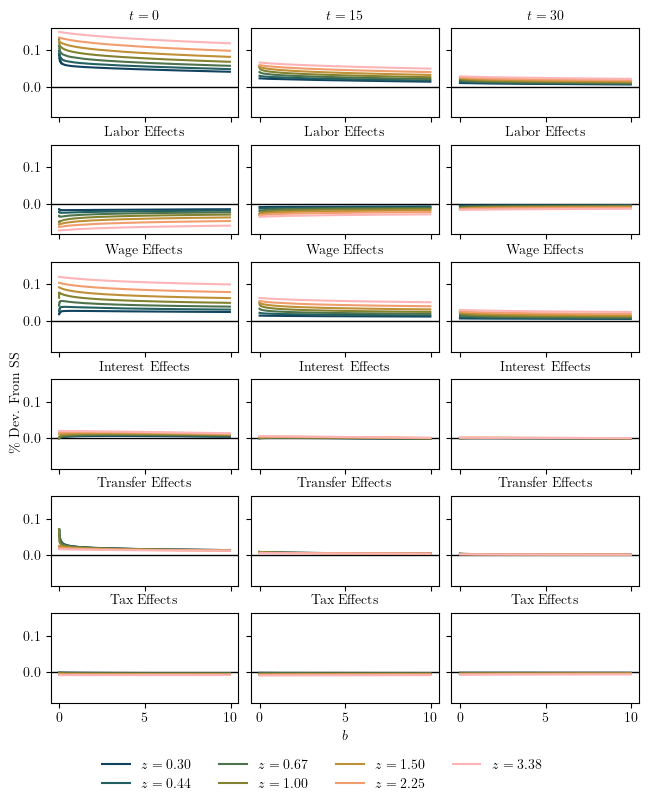

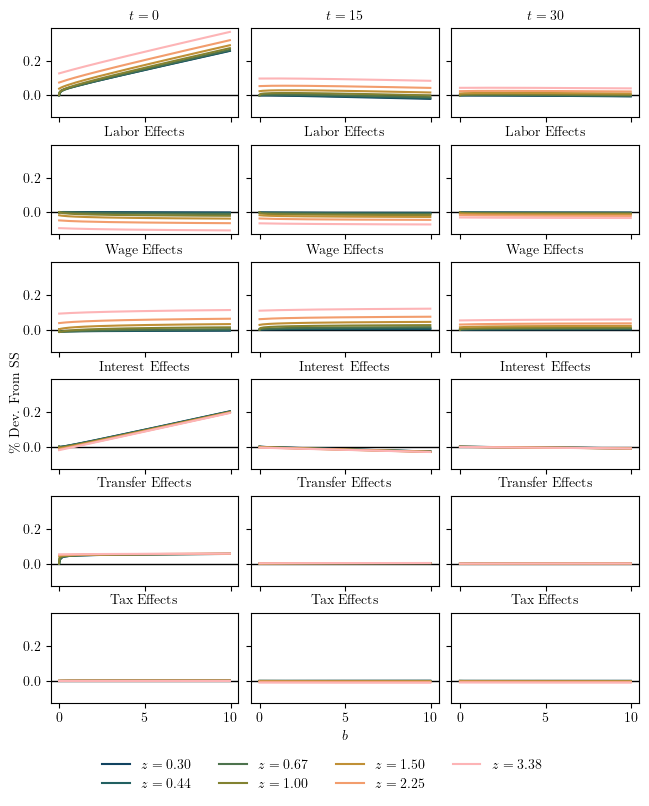

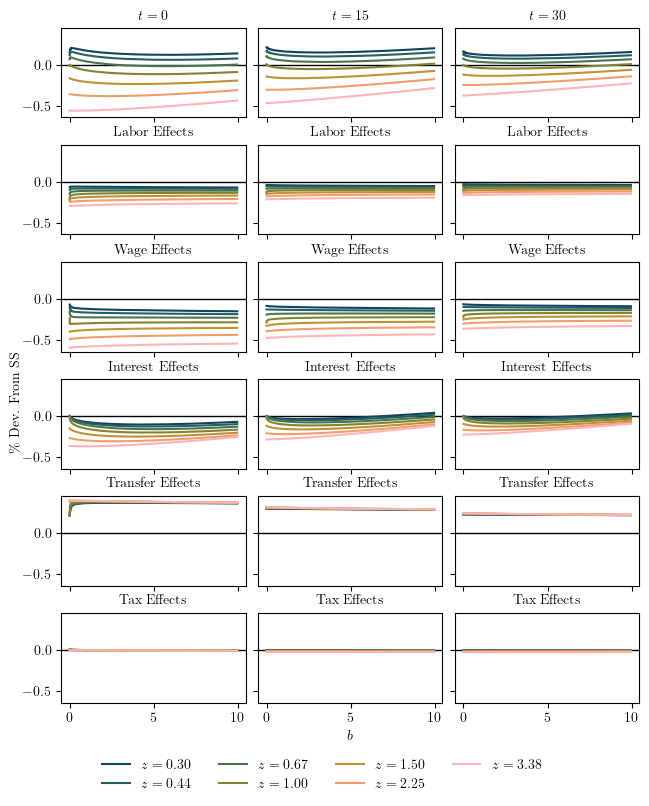

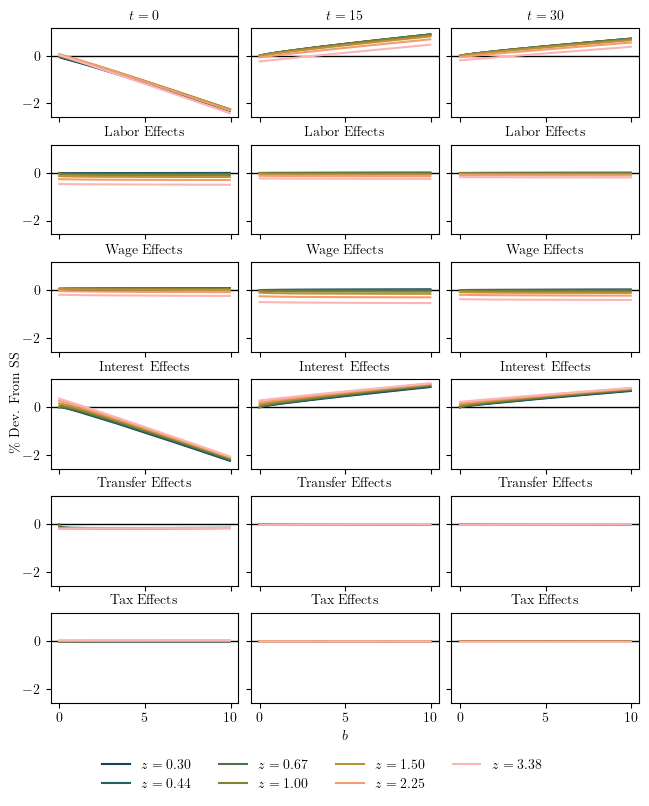

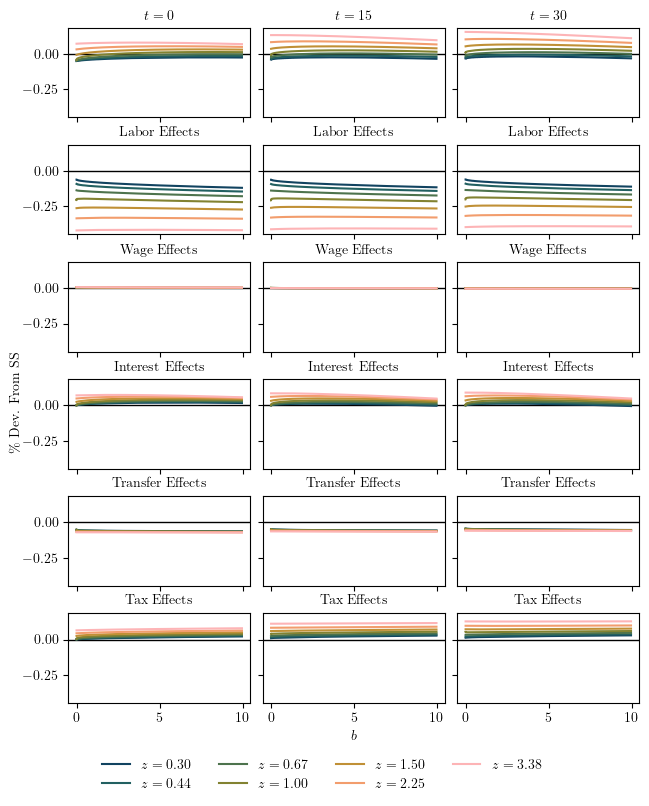

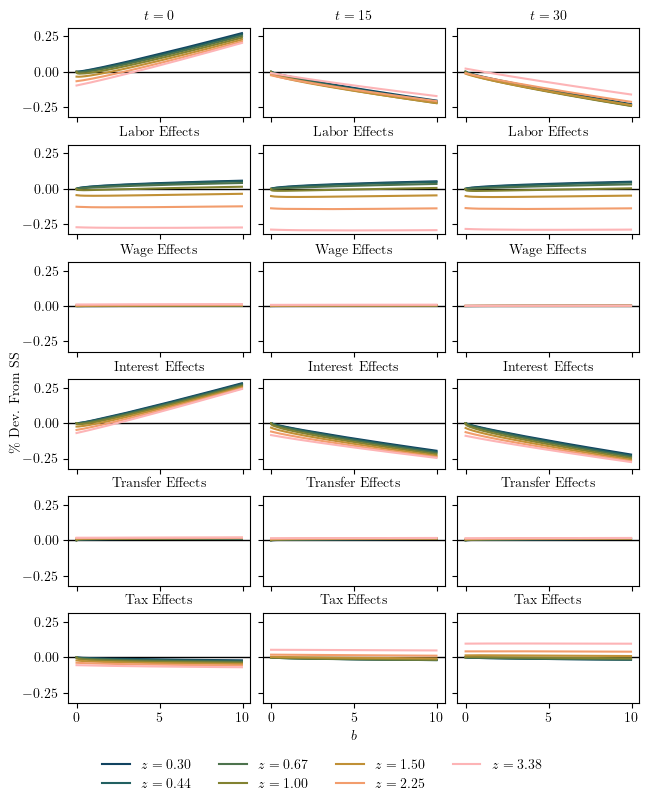

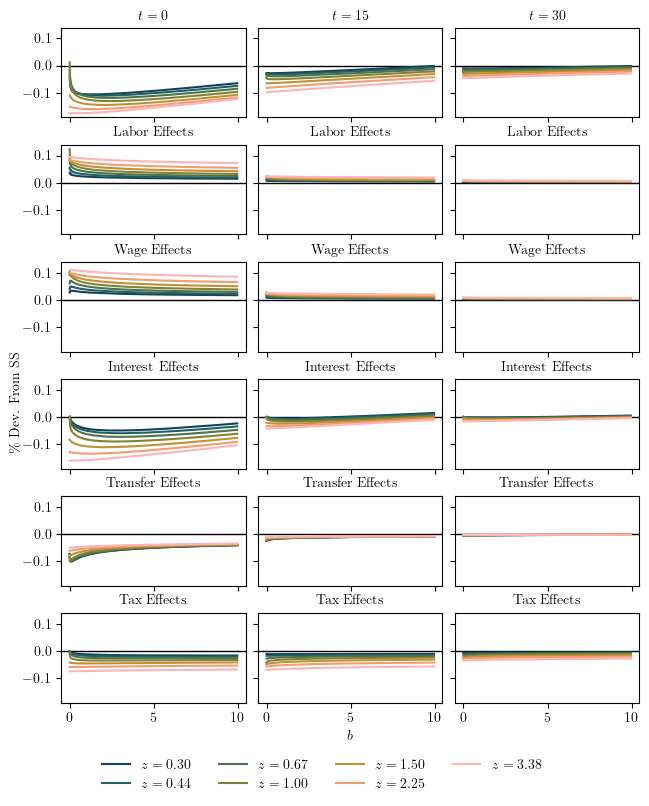

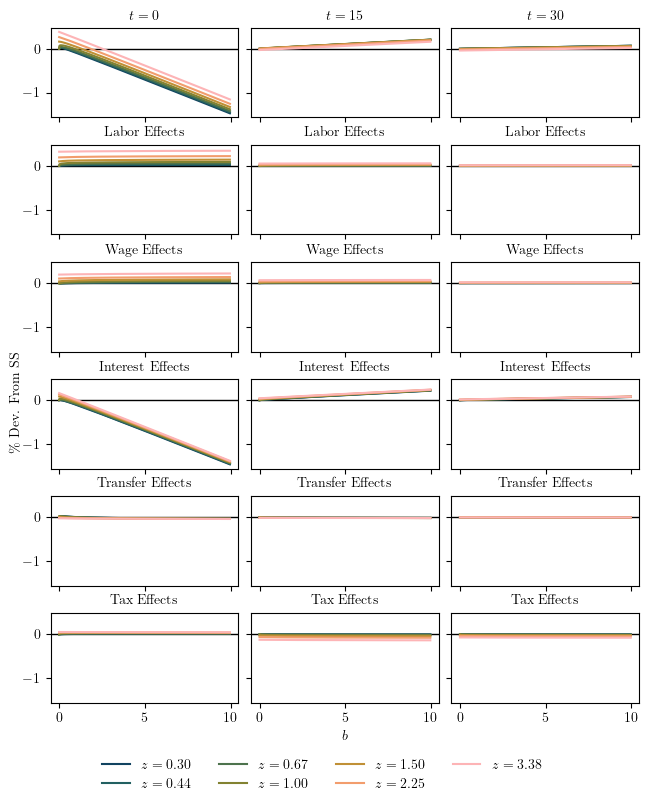

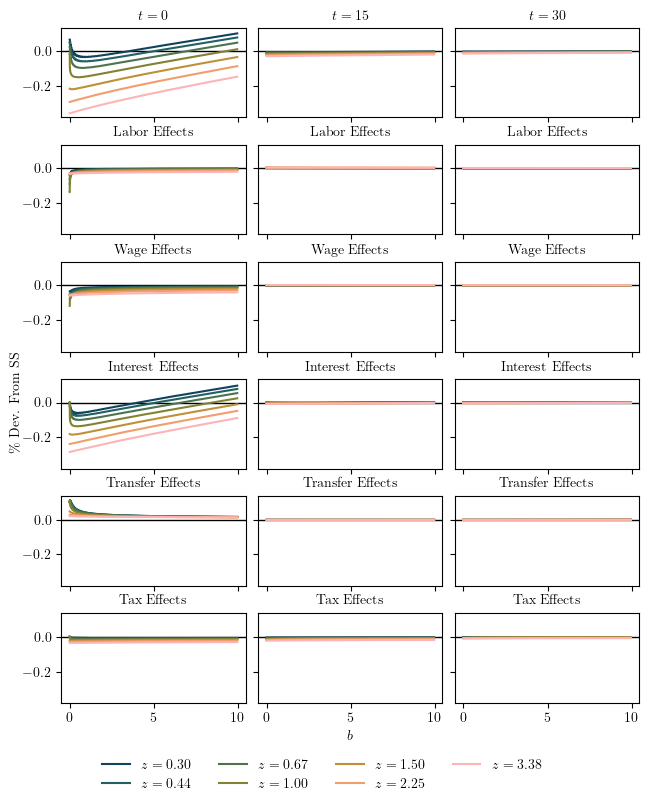

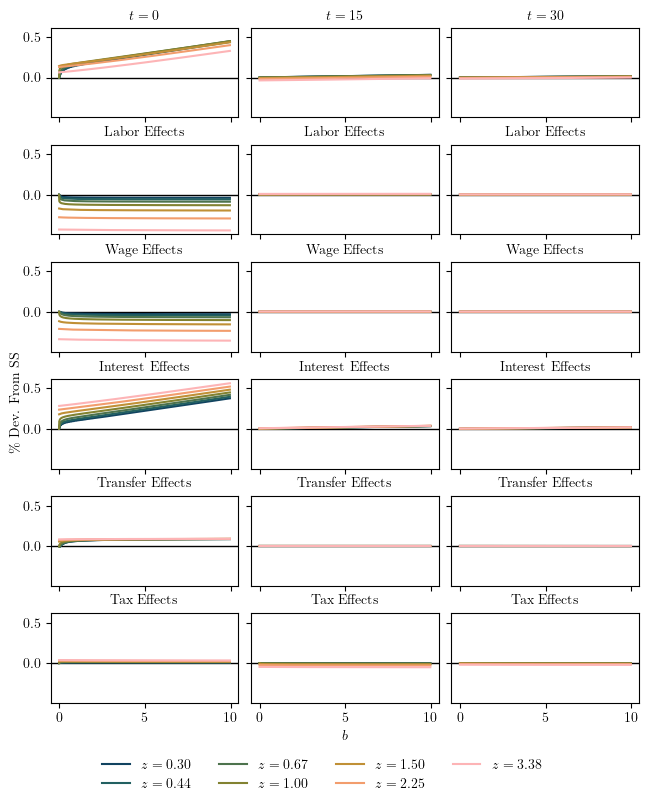

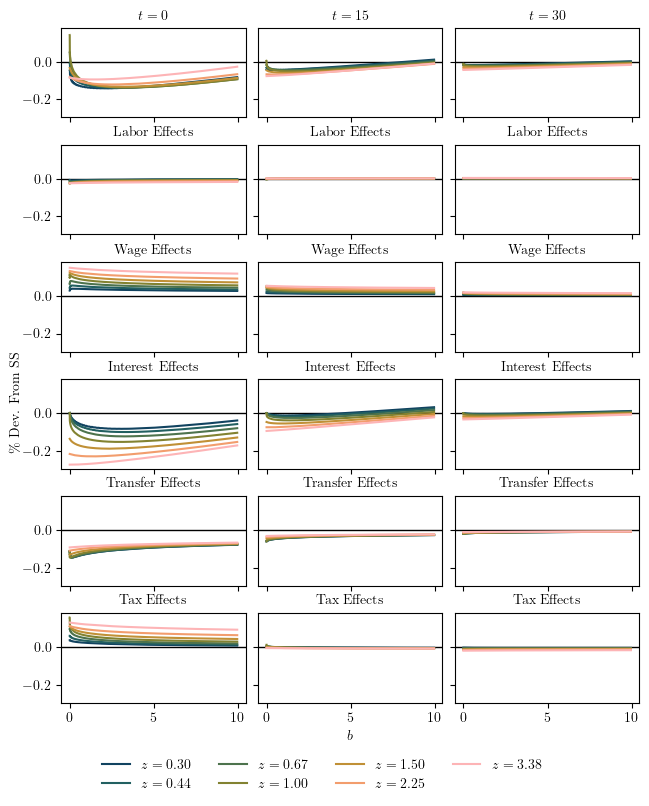

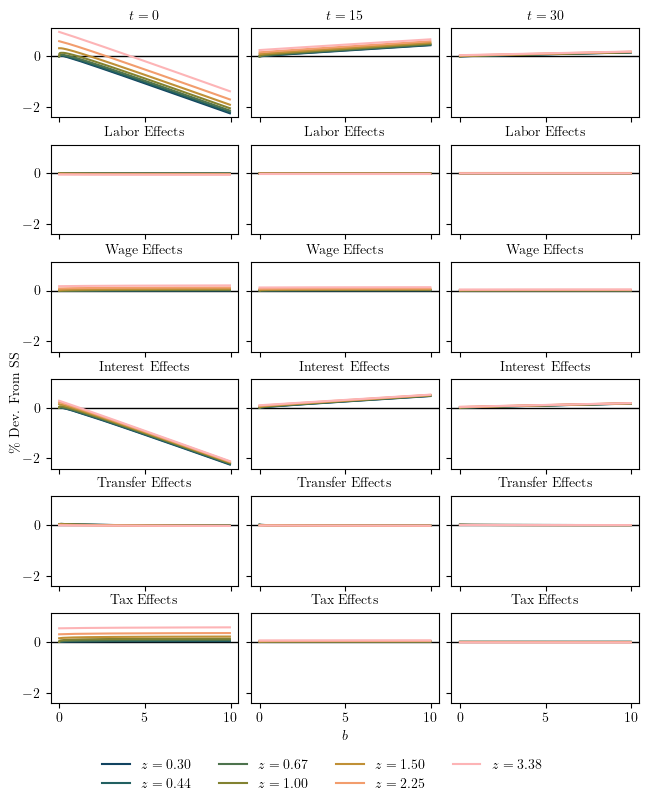

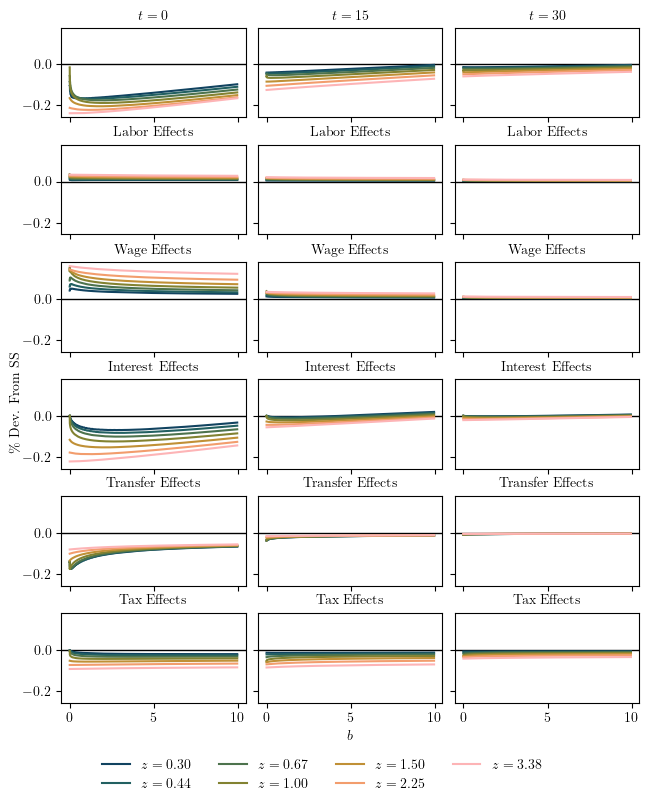

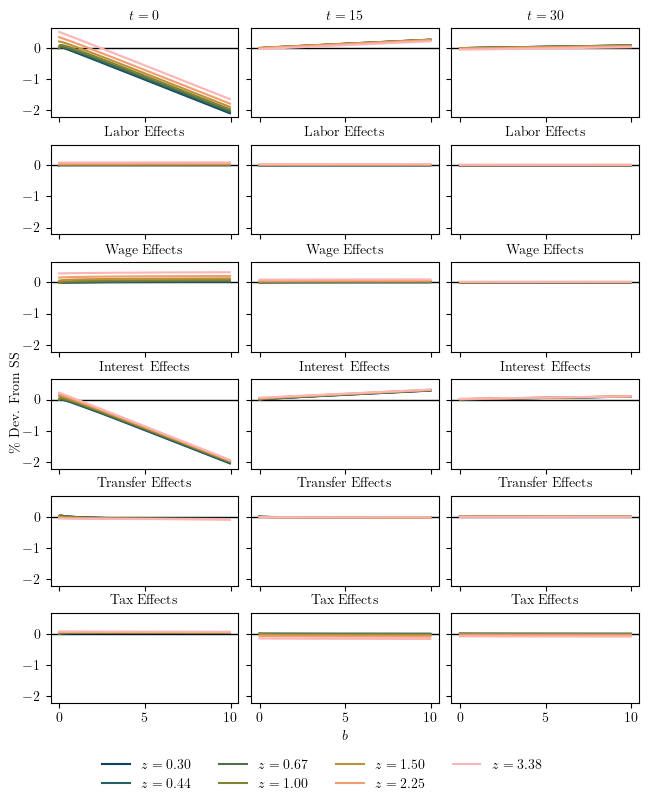

In [11]:
## decompose the impulse response function
irf_decomp = decompose_all_irfs(G, hank.int_block_jacs, {Z: ar_shock_irf(rhos[Z], T, sigmas[Z]) for Z in G.keys()}, hank.shocks, dxs=dxs)

for Z in irf_decomp.keys():
    for x in ['c', 'a']:
        ## plot policy rule irfs
        fig, axs = plt.subplots(6, 3, sharey=True, sharex=True)
        fig.set_figheight(8)
        fig.set_figwidth(6.5)
        axs[-1, 1].set_xlabel('$b$')
        fig.supylabel(r'\% Dev. From SS')
        n = (hank.a_grid < 10).sum()
        for ax in axs.ravel():
            ax.axhline(0, c='k', lw=1)

        ## plot irf at t
        for i, t in enumerate([0, 15, 30]):
            # formating
            axs[0, i].set_title(f'$t = {t}$')

            # decomposition
            axs[1, i].set_title('Labor Effects')
            L_irf = irf_decomp[Z][x]['L'][t, :n]
            axs[1, i].plot(hank.a_grid[:n], L_irf)
            axs[2, i].set_title('Wage Effects')
            W_irf = irf_decomp[Z][x]['W'][t, :n]
            axs[2, i].plot(hank.a_grid[:n], W_irf)
            axs[3, i].set_title('Interest Effects')
            R_irf = irf_decomp[Z][x]['R'][t, :n]
            axs[3, i].plot(hank.a_grid[:n], R_irf)
            axs[4, i].set_title('Transfer Effects')
            T_irf = irf_decomp[Z][x]['D'][t, :n] + irf_decomp[Z][x].get('eta', np.zeros(T)[:, None])[t, :n]
            axs[4, i].plot(hank.a_grid[:n], T_irf)
            axs[5, i].set_title('Tax Effects')
            tau_irf = irf_decomp[Z][x]['tauL'][t, :n] + irf_decomp[Z][x].get('tauP', np.zeros(T)[:, None])[t, :n]
            axs[5, i].plot(hank.a_grid[:n], tau_irf)

            # whole thing
            lns = axs[0, i].plot(hank.a_grid[:n], W_irf + R_irf + T_irf + tau_irf, label=[f'$z = {z:.2f}$' for z in hank.z_grid])

        # fig.legend(handles=lns)
        fig.tight_layout(pad=0.5)
        fig.subplots_adjust(bottom=1/8)
        fig.legend(handles=lns, ncol=4, loc='lower center', bbox_to_anchor=(0.5, 0), frameon=False)
        if save: fig.savefig(f'paper/figures/{x}_{Z[3:]}_irf.pgf')